# Plenoptic ToolBox Dataset to LLFF (DyNeRF) format

The numpy matrix will have shape (# images, 17), where [:, 0:15] is the flattened 3x5 pose&intrinsics matrix and [:, -2:] contains the near and far bounds for each camera (we fixed this and likely wont use contraction so default will be used instead of this).
The 3x5 pose and intrics matrix consist of the 3x4 transformation matrix (without [0, 0, 0, 1]) and 1x3 matrix containing height H, width w and focal F.

The focal calculated for the 2x downsampled scene is 1333.33 - so we 2x it to get the focal for the non-downsampled set.

In [1]:
import os

# Set the plenoptic toolbox (ptb) config and video files
config_fp ='../data/plenoptic_toolbox/161029_sports1/calibration_161029_sports1.json'
compare_config_fp ='../data/luca_dnerf/transforms_train.json'
video_fp = '../data/plenoptic_toolbox/161029_sports1/hdVideos/'
# Assert input data exists
assert os.path.exists(config_fp), AssertionError(f'Config Non-Existent : {config_fp}')
assert os.path.exists(video_fp), AssertionError(f'Config Non-Existent : {video_fp}')
assert os.path.exists(compare_config_fp), AssertionError(f'Config Non-Existent : {compare_config_fp}')

# Set the video type
if 'hdVideos' in video_fp:
    camType = 'hd'
elif 'vgaVideos' in video_fp:
    camType = 'vga'
else: # default currently assumes VGA camera dataset
    camType = 'vga'

# Create destination for the  new dataset
output_fp = '../data/plenoptic_toolbox/161029_sports1/llff/'
os.makedirs(output_fp, exist_ok=True) # create root folder


In [2]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

with open(config_fp, 'r') as fp:
    config = json.load(fp)

with open(compare_config_fp, 'r') as fp:
    comp_config = json.load(fp)

Text(0.5, 0, 'Z Axis')

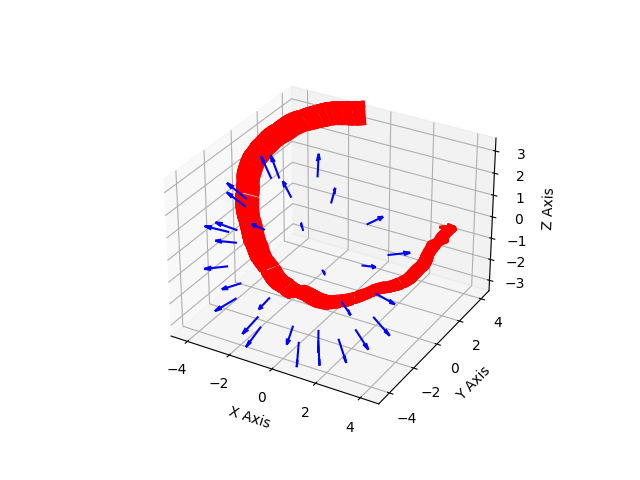

In [3]:
fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')

# Initialise used_frame dict
used_frames = {} # dict for storing "[camera]":[frame0, frame 12, frame 129, ...] (frames used in train and/or test)

# Filter through camera data and store video pose data
cameras = []
camera_meta = []
for cam in config['cameras']:
    if cam['type'] == 'hd':
        # Construct a 4x4 transformation matrix
        R = np.matrix(cam['R'])
        t = np.array(cam['t'])
        transformation_matrix = np.eye(4)
        transformation_matrix[:3, :3] = -R.transpose()
        cc = (-R.transpose()*t)
        transformation_matrix[:3, 3] =cc.flatten()/80. # Here we re-scale scene from 300x300x300 to 4x4x4 (not exactly 4 but nearly)
        
        uvw = transformation_matrix[:3, 2]
        xyz = transformation_matrix[:3, 3]
        ax.quiver(xyz[0], xyz[1], xyz[2], uvw[0], uvw[1], uvw[2], color='b', length=1)

        cameras.append(torch.from_numpy(transformation_matrix))
        camera_meta.append(cam)
        
for cam in comp_config['frames']:
    transformation_matrix = np.matrix(cam["transform_matrix"])
    uvw = transformation_matrix[:3, 2]
    xyz = transformation_matrix[:3, 3]
    ax.quiver(xyz[0], xyz[1], xyz[2], uvw[0], uvw[1], uvw[2], color='r', length=1)

# Customize the plot as needed
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
# plt.show()

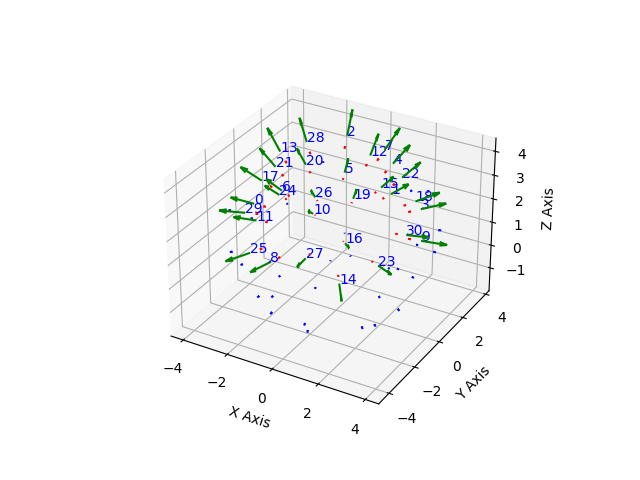

In [5]:
def get_Rotation(angx, angy,angz):
                # Convert deg to radians
        angz = angz * np.pi / 180.
        angx = angx * np.pi / 180
        angy = angy * np.pi / 180
        Rz = torch.tensor([[np.cos(angz), -np.sin(angz), 0],
                        [np.sin(angz), np.cos(angz), 0],
                        [0, 0, 1]], dtype=torch.double) # Construct rotation transform
        Rx = torch.tensor([[np.cos(angx), 0, np.sin(angx)],
                        [0, 1, 0.],
                        [-np.sin(angx), 0, np.cos(angx)]
                                ], dtype=torch.double)
        Ry = torch.tensor([[1, 0, 0],
                        [0, np.cos(angy), -np.sin(angy)],
                        [0, np.sin(angy), np.cos(angy)]
                                ], dtype=torch.double)

        # Get world rotation
        R = torch.mm(Ry, Rx)
        R = torch.mm(Rz, R)
        R = torch.cat([R.T, torch.tensor([[0., 0., 0.]], dtype=torch.double)],dim=0).T
        return R

# Set the angles for rotation around axis lines
angx=0
angy=275
angz=0

R = get_Rotation(angx, angy, angz)
fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')

# Initialise used_frame dict
used_frames = {} # dict for storing "[camera]":[frame0, frame 12, frame 129, ...] (frames used in train and/or test)

cameras_ = []
# Filter through camera data and store video pose data
for i, cam in enumerate(cameras):
    transformation_matrix = cam
    uvw = transformation_matrix[:3, 2]
    xyz = transformation_matrix[:3, 3]

    # ax.quiver(xyz[0], xyz[1], xyz[2], uvw[0], uvw[1], uvw[2], color='b', length=1)

    transformation_matrix = torch.matmul(R, transformation_matrix)
    uvw = transformation_matrix[:3, 2]
    xyz = transformation_matrix[:3, 3]
    ax.text(xyz[0], xyz[1], xyz[2], f'{i}', color='b')
    ax.quiver(xyz[0], xyz[1], xyz[2], uvw[0], uvw[1], uvw[2], color='g', length=1)    

    xyz = xyz-.5*uvw
    ax.quiver(xyz[0], xyz[1], xyz[2], uvw[0], uvw[1], uvw[2], color='r', length=0.1)    

    xyz = xyz-7.*uvw
    ax.quiver(xyz[0], xyz[1], xyz[2], uvw[0], uvw[1], uvw[2], color='b', length=.1)    
    cameras_.append(transformation_matrix.unsqueeze(0))
# Customize the plot as needed
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
cameras = torch.cat(cameras_)

plt.show()

In [6]:

# Inset Intrinsics and near-fars (only used for scene contraction)
H,W = 1080,1920
focal = 2666.6664748650437
intrinsics = torch.tensor([[H, W, focal]]).repeat(cameras.shape[0], 1).unsqueeze(-1)

near_fars = torch.tensor([[0.5, 7.0]]).repeat(cameras.shape[0], 1)



poses = torch.cat([cameras, intrinsics], dim=-1).flatten(1,2)
poses_bounds = torch.cat([poses, near_fars], dim=-1).numpy()

In [62]:
import shutil

numCams = 20

poses_bounds = poses_bounds[:numCams]
print(poses_bounds.shape)
for i, cam in enumerate(camera_meta):
    if i < numCams:
        src = video_fp+'hd_'+cam['name']+'.mp4'
        dst = output_fp+'cam'+cam['name'].split('_')[-1]+'.mp4'
        shutil.copyfile(src, dst)

dst = output_fp+'poses_bounds.npy'
np.save(dst, poses_bounds)

(20, 17)
